In [81]:
import pandas as pd
energy = pd.read_csv("/Users/fabiolarojas/Documents/data-science/dtsc2103:2/2302project/energydf.csv")


In [82]:
energy['time'].dtype

dtype('O')

In [83]:
try:
    energy['time'] = pd.to_datetime(energy['time'], utc=True)
    print("Successfully converted 'time' column to datetime type.")
except ValueError as e:
    print("Error encountered while converting 'time' column:", e)

energy['time'].dtype

Successfully converted 'time' column to datetime type.


datetime64[ns, UTC]

## winter dataset

In [96]:

energy['year'] = energy['time'].dt.year
energy['month'] = energy['time'].dt.month

winter_months = [12, 1, 2, 3]

winter_energy = energy[(energy['year'].isin([2015, 2016, 2017, 2018])) & (energy['month'].isin(winter_months))]

winter_energy = winter_energy.drop(['year', 'month'], axis=1)
winter_energy

,time,generation biomass,generation fossil,generation hydro,generation nuclear,generation solar,generation waste,generation wind onshore,generation other,generation other renewable,total load forecast,total load actual,price day ahead,price actual
1,2015-01-01 00:00:00+00:00,449.0,10437.0,3587.0,7096.0,50.0,195.0,5890.0,43.0,71.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 01:00:00+00:00,448.0,9918.0,3508.0,7099.0,50.0,196.0,5461.0,43.0,73.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 02:00:00+00:00,438.0,8859.0,3231.0,7098.0,50.0,191.0,5238.0,43.0,75.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 03:00:00+00:00,428.0,8313.0,3499.0,7097.0,42.0,189.0,4935.0,43.0,74.0,21785.0,20264.0,38.41,56.04
5,2015-01-01 04:00:00+00:00,410.0,7962.0,3804.0,7098.0,34.0,188.0,4618.0,43.0,74.0,21441.0,19905.0,35.72,53.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35013,2018-12-31 18:00:00+00:00,297.0,10440.0,5972.0,6073.0,85.0,277.0,3113.0,63.0,95.0,30619.0,30653.0,68.85,77.02
35014,2018-12-31 19:00:00+00:00,296.0,9981.0,5104.0,6074.0,33.0,280.0,3288.0,62.0,95.0,29932.0,29735.0,68.40,76.16
35015,2018-12-31 20:00:00+00:00,292.0,9615.0,4029.0,6076.0,31.0,286.0,3503.0,61.0,94.0,27903.0,28071.0,66.88,74.30
35016,2018-12-31 21:00:00+00:00,293.0,9018.0,3304.0,6075.0,31.0,287.0,3586.0,61.0,93.0,25450.0,25801.0,63.93,69.89


### winter model

In [106]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

X = winter_energy[["price day ahead", "generation fossil", "total load forecast", 
                   "generation nuclear", "generation other renewable", "generation waste", 
                   "generation biomass"]]
y = winter_energy["price actual"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

r_squared = xgb_model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

n = len(y)
k = X.shape[1]
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)

print("R-squared:", r_squared)
print("Adjusted R-squared:", adjusted_r_squared)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)


R-squared: 0.8422589803754794
Adjusted R-squared: 0.8421638574311848
Mean Absolute Error: 4.4046921884172345
Mean Squared Error: 47.537397815553575
Root Mean Squared Error: 6.894736964928653


### price prediction using summer predictor means

In [86]:
import numpy as np

new_data_point = np.array([[5145, 11210, 28960, 6372, 85, 282, 394]])

predicted_price = xgb_model.predict(new_data_point)

print("Predicted price:", predicted_price)


Predicted price: [102.60108]


### price prediction using winter predictor means

In [87]:
new_data_point = np.array([[4847, 10085, 29160, 6512, 85, 262, 389]])

predicted_price = xgb_model.predict(new_data_point)

print("Predicted price:", predicted_price)


Predicted price: [100.19817]


### first line of winter dataset (actual 64.92)

In [88]:
new_data_point = np.array([[48.10, 10437, 24934, 7096, 71, 195, 449]])

predicted_price = xgb_model.predict(new_data_point)

print("Predicted price:", predicted_price)

Predicted price: [59.25211]


### first line of summer dataset (actual 54.54)

In [89]:
new_data_point = np.array([[46, 11151, 21585, 7098, 72, 244, 495]])

predicted_price = xgb_model.predict(new_data_point)

print("Predicted price:", predicted_price)

Predicted price: [43.943672]


In [117]:
#summer values
new_data_point = np.array([[46, 11151, 21585, 7098, 72, 244, 495], 
                           [43.84, 10300, 20453, 7099, 73, 248, 495], 
                           [40.13, 9901, 19751, 7099, 71, 248, 491], 
                           [61.19, 8100, 25432, 7002, 94, 317, 347], 
                           [61.58, 11363, 28908, 6081, 90, 320, 265], 
                           [51, 10812, 26777, 6080, 90, 319, 262]])

predicted_price = xgb_model.predict(new_data_point)

print("Predicted price:", predicted_price)

Predicted price: [43.943672 40.15126  35.897648 67.82314  63.22714  57.629898]


In [118]:

#winter values
new_data_point = np.array([[48.1, 10437, 24934, 7096, 71, 195, 449], 
[47.33, 9918, 23515, 7099, 73, 196, 448], 
[42.27, 8859, 22642, 7098, 75, 191, 438], 
[66.88, 9615, 27903, 6076, 94, 286, 292], 
[63.93, 9018, 25450, 6075, 93, 287, 293], 
[64.27, 9255, 24424, 6075, 92, 287, 290]])

predicted_price = xgb_model.predict(new_data_point)

print("Predicted price:", predicted_price)

Predicted price: [59.25211  56.728714 55.25217  75.18591  72.88397  70.799545]


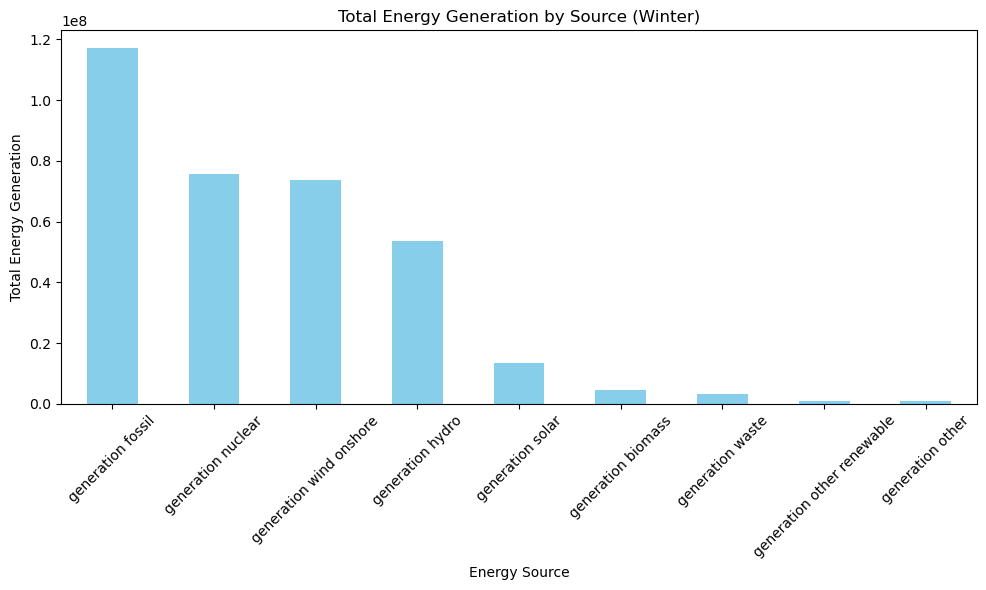

In [123]:
import matplotlib.pyplot as plt

# Aggregate total energy generation for each energy source
energy_generation_totals = winter_energy[["generation biomass", "generation fossil", "generation hydro", 
                                         "generation nuclear", "generation solar", "generation waste", 
                                         "generation wind onshore", "generation other", "generation other renewable"]].sum()

# Sort the energy generation totals in descending order
energy_generation_totals = energy_generation_totals.sort_values(ascending=False)

# Plot the energy generation totals
plt.figure(figsize=(10, 6))
energy_generation_totals.plot(kind='bar', color='skyblue')
plt.title('Total Energy Generation by Source (Winter)')
plt.xlabel('Energy Source')
plt.ylabel('Total Energy Generation')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from getting cut off
plt.show()


## summer dataset

In [97]:

energy['year'] = energy['time'].dt.year
energy['month'] = energy['time'].dt.month

summer_months = [6, 7, 8, 9]

summer_energy = energy[(energy['year'].isin([2015, 2016, 2017, 2018])) & (energy['month'].isin(summer_months))]

summer_energy = summer_energy.drop(['year', 'month'], axis=1)
summer_energy

,time,generation biomass,generation fossil,generation hydro,generation nuclear,generation solar,generation waste,generation wind onshore,generation other,generation other renewable,total load forecast,total load actual,price day ahead,price actual
3597,2015-06-01 00:00:00+00:00,495.0,11151.0,2877.0,7098.0,31.0,244.0,2815.0,43.0,72.0,21585.0,22118.0,46.00,54.54
3598,2015-06-01 01:00:00+00:00,495.0,10300.0,3010.0,7099.0,31.0,248.0,3008.0,43.0,73.0,20453.0,21015.0,43.84,53.87
3599,2015-06-01 02:00:00+00:00,491.0,9901.0,3675.0,7099.0,31.0,248.0,3205.0,43.0,71.0,19751.0,20518.0,40.13,54.20
3600,2015-06-01 03:00:00+00:00,493.0,9764.0,3773.0,7097.0,31.0,246.0,3287.0,43.0,69.0,19559.0,20478.0,40.00,55.87
3601,2015-06-01 04:00:00+00:00,488.0,10188.0,3777.0,7096.0,31.0,246.0,3382.0,43.0,71.0,20002.0,20926.0,43.32,61.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32806,2018-09-30 19:00:00+00:00,355.0,9139.0,1917.0,7000.0,366.0,318.0,6520.0,60.0,97.0,28478.0,28267.0,74.27,80.15
32807,2018-09-30 20:00:00+00:00,354.0,8491.0,1501.0,7002.0,238.0,319.0,7155.0,60.0,95.0,27191.0,26944.0,69.50,75.59
32808,2018-09-30 21:00:00+00:00,347.0,8100.0,1509.0,7002.0,146.0,317.0,7223.0,59.0,94.0,25432.0,25178.0,61.19,66.90
32809,2018-09-30 22:00:00+00:00,265.0,11363.0,3395.0,6081.0,16.0,320.0,6757.0,48.0,90.0,28908.0,29001.0,61.58,64.64


### summer model

In [120]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

X = summer_energy[["price day ahead", "generation fossil", "total load forecast", 
                   "generation nuclear", "generation other renewable", "generation waste", 
                   "generation biomass"]]
y = summer_energy["price actual"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

r_squared = xgb_model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

n = len(y)
k = X.shape[1]
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)

print("R-squared:", r_squared)
print("Adjusted R-squared:", adjusted_r_squared)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)


R-squared: 0.9131939529493077
Adjusted R-squared: 0.9131420043873384
Mean Absolute Error: 2.229311546055184
Mean Squared Error: 11.081109453576536
Root Mean Squared Error: 3.3288300427592477


### price prediction using winter predictor means

In [92]:
new_data_point = np.array([[4847, 10085, 29160, 6512, 85, 262, 389]])

predicted_price = xgb_model.predict(new_data_point)

print("Predicted price:", predicted_price)


Predicted price: [67.09307]


### price prediction using summer predictor means

In [93]:
new_data_point = np.array([[5145, 11210, 28960, 6372, 85, 282, 394]])

predicted_price = xgb_model.predict(new_data_point)

print("Predicted price:", predicted_price)

Predicted price: [65.99147]


### first line of summer dataset (actual 54.54)

In [94]:
new_data_point = np.array([[46, 11151, 21585, 7098, 72, 244, 495]])

predicted_price = xgb_model.predict(new_data_point)

print("Predicted price:", predicted_price)

Predicted price: [57.868423]


### first line of winter dataset (actual 64.92)

In [95]:
new_data_point = np.array([[48.10, 10437, 24934, 7096, 71, 195, 449]])

predicted_price = xgb_model.predict(new_data_point)

print("Predicted price:", predicted_price)

Predicted price: [61.945827]


In [122]:
#summer values
new_data_point = np.array([[46, 11151, 21585, 7098, 72, 244, 495], 
                           [43.84, 10300, 20453, 7099, 73, 248, 495], 
                           [40.13, 9901, 19751, 7099, 71, 248, 491], 
                           [61.19, 8100, 25432, 7002, 94, 317, 347], 
                           [61.58, 11363, 28908, 6081, 90, 320, 265], 
                           [51, 10812, 26777, 6080, 90, 319, 262]])

predicted_price = xgb_model.predict(new_data_point)

print("Predicted price:", predicted_price)

Predicted price: [57.868423 54.502537 56.413185 66.58016  66.622795 59.34052 ]


In [121]:

#winter values
new_data_point = np.array([[48.1, 10437, 24934, 7096, 71, 195, 449], 
[47.33, 9918, 23515, 7099, 73, 196, 448], 
[42.27, 8859, 22642, 7098, 75, 191, 438], 
[66.88, 9615, 27903, 6076, 94, 286, 292], 
[63.93, 9018, 25450, 6075, 93, 287, 293], 
[64.27, 9255, 24424, 6075, 92, 287, 290]])

predicted_price = xgb_model.predict(new_data_point)

print("Predicted price:", predicted_price)

Predicted price: [61.945827 56.99205  54.078285 61.348625 52.114857 51.384274]


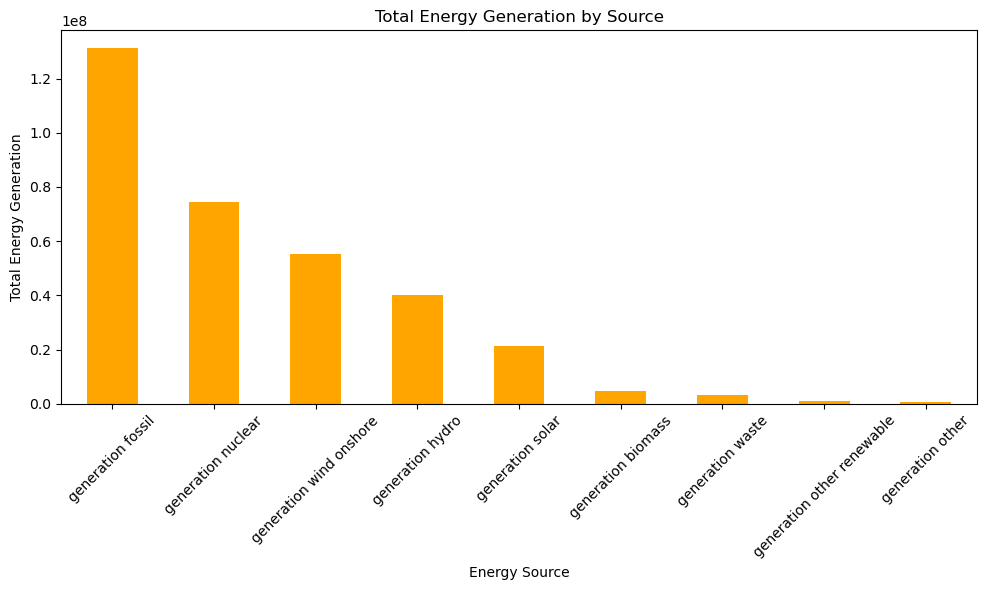

In [116]:
import matplotlib.pyplot as plt

# Aggregate total energy generation for each energy source
energy_generation_totals = summer_energy[["generation biomass", "generation fossil", "generation hydro", 
                                         "generation nuclear", "generation solar", "generation waste", 
                                         "generation wind onshore", "generation other", "generation other renewable"]].sum()

# Sort the energy generation totals in descending order
energy_generation_totals = energy_generation_totals.sort_values(ascending=False)

# Plot the energy generation totals
plt.figure(figsize=(10, 6))
energy_generation_totals.plot(kind='bar', color='orange')
plt.title('Total Energy Generation by Source')
plt.xlabel('Energy Source')
plt.ylabel('Total Energy Generation')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from getting cut off
plt.show()


<Figure size 1200x600 with 0 Axes>

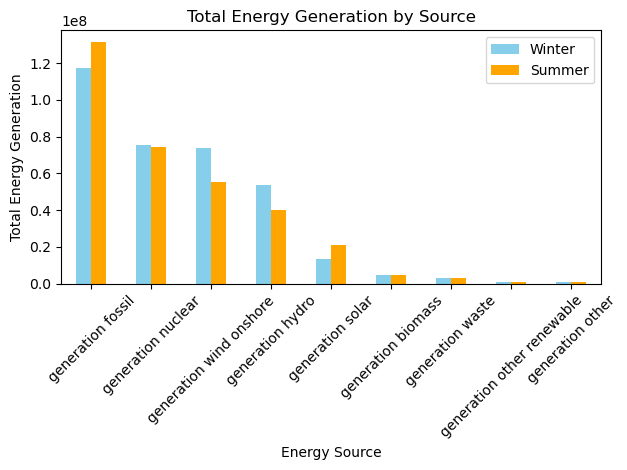

In [126]:
import matplotlib.pyplot as plt
import pandas as pd

# Aggregate total energy generation for each energy source for winter
energy_generation_totals_winter = winter_energy[["generation biomass", "generation fossil", "generation hydro", 
                                                 "generation nuclear", "generation solar", "generation waste", 
                                                 "generation wind onshore", "generation other", 
                                                 "generation other renewable"]].sum()
energy_generation_totals_winter = energy_generation_totals_winter.sort_values(ascending=False)

# Aggregate total energy generation for each energy source for summer
energy_generation_totals_summer = summer_energy[["generation biomass", "generation fossil", "generation hydro", 
                                                 "generation nuclear", "generation solar", "generation waste", 
                                                 "generation wind onshore", "generation other", 
                                                 "generation other renewable"]].sum()
energy_generation_totals_summer = energy_generation_totals_summer.sort_values(ascending=False)

# Combine winter and summer energy generation totals into a single DataFrame
combined_totals = pd.concat([energy_generation_totals_winter, energy_generation_totals_summer], axis=1)
combined_totals.columns = ['Winter', 'Summer']

# Plotting
plt.figure(figsize=(12, 6))
combined_totals.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Total Energy Generation by Source')
plt.xlabel('Energy Source')
plt.ylabel('Total Energy Generation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

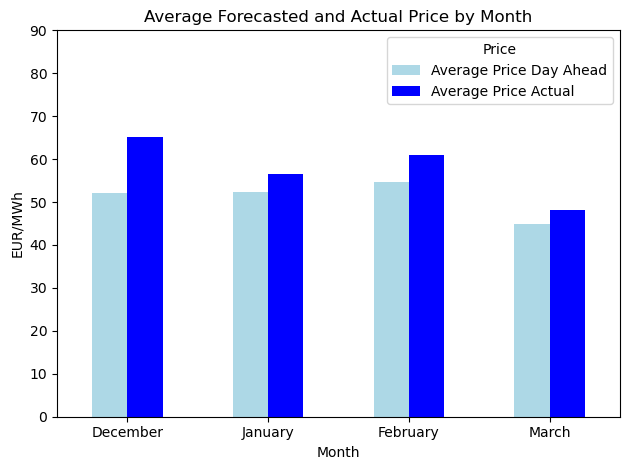

In [146]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have loaded your dataset into a DataFrame named winter_energy

# Convert 'date' column to datetime type
winter_energy['time'] = pd.to_datetime(winter_energy['time'])

# Filter the dataset for each month (December, January, February, March)
dec_data = winter_energy[(winter_energy['time'].dt.year == 2017) & (winter_energy['time'].dt.month == 12)]
jan_data = winter_energy[(winter_energy['time'].dt.year == 2018) & (winter_energy['time'].dt.month == 1)]
feb_data = winter_energy[(winter_energy['time'].dt.year == 2018) & (winter_energy['time'].dt.month == 2)]
mar_data = winter_energy[(winter_energy['time'].dt.year == 2018) & (winter_energy['time'].dt.month == 3)]

# Calculate the average "price day ahead" and "price actual" for each month
dec_avg_price_day_ahead = dec_data['price day ahead'].mean()
dec_avg_price_actual = dec_data['price actual'].mean()

jan_avg_price_day_ahead = jan_data['price day ahead'].mean()
jan_avg_price_actual = jan_data['price actual'].mean()

feb_avg_price_day_ahead = feb_data['price day ahead'].mean()
feb_avg_price_actual = feb_data['price actual'].mean()

mar_avg_price_day_ahead = mar_data['price day ahead'].mean()
mar_avg_price_actual = mar_data['price actual'].mean()

# Create a DataFrame with the average values for each month
monthly_avg_prices = pd.DataFrame({
    'Month': ['December', 'January', 'February', 'March'],
    'Average Price Day Ahead': [dec_avg_price_day_ahead, jan_avg_price_day_ahead, feb_avg_price_day_ahead, mar_avg_price_day_ahead],
    'Average Price Actual': [dec_avg_price_actual, jan_avg_price_actual, feb_avg_price_actual, mar_avg_price_actual]
})

# Plot the double bar graph
plt.figure(figsize=(10, 6))
ax = monthly_avg_prices.plot(x='Month', kind='bar', color=['lightblue', 'blue'])
plt.title('Average Forecasted and Actual Price by Month')
plt.xlabel('Month')
plt.ylabel('EUR/MWh')
plt.xticks(rotation=0)
ax.legend(title='Price', loc='upper right')
plt.ylim(0, 90)
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

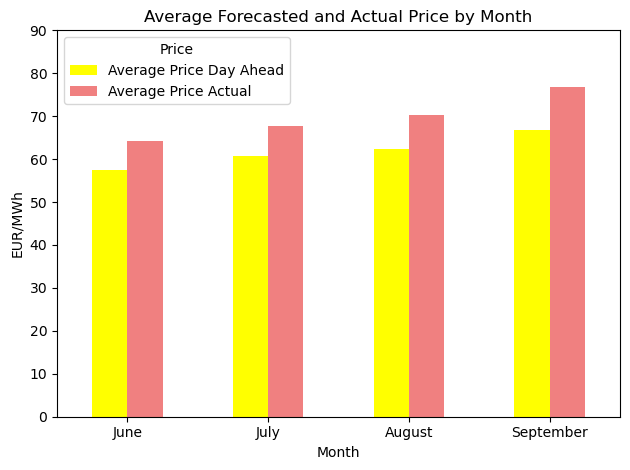

In [143]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have loaded your dataset into a DataFrame named summer_energy

# Convert 'date' column to datetime type
summer_energy['time'] = pd.to_datetime(summer_energy['time'])

# Filter the dataset for each month (June, July, August, September)
jun_data = summer_energy[(summer_energy['time'].dt.year == 2018) & (summer_energy['time'].dt.month == 6)]
jul_data = summer_energy[(summer_energy['time'].dt.year == 2018) & (summer_energy['time'].dt.month == 7)]
aug_data = summer_energy[(summer_energy['time'].dt.year == 2018) & (summer_energy['time'].dt.month == 8)]
sep_data = summer_energy[(summer_energy['time'].dt.year == 2018) & (summer_energy['time'].dt.month == 9)]

# Calculate the average "price day ahead" and "price actual" for each month
jun_avg_price_day_ahead = jun_data['price day ahead'].mean()
jun_avg_price_actual = jun_data['price actual'].mean()

jul_avg_price_day_ahead = jul_data['price day ahead'].mean()
jul_avg_price_actual = jul_data['price actual'].mean()

aug_avg_price_day_ahead = aug_data['price day ahead'].mean()
aug_avg_price_actual = aug_data['price actual'].mean()

sep_avg_price_day_ahead = sep_data['price day ahead'].mean()
sep_avg_price_actual = sep_data['price actual'].mean()

# Create a DataFrame with the average values for each month
monthly_avg_prices = pd.DataFrame({
    'Month': ['June', 'July', 'August', 'September'],
    'Average Price Day Ahead': [jun_avg_price_day_ahead, jul_avg_price_day_ahead, aug_avg_price_day_ahead, sep_avg_price_day_ahead],
    'Average Price Actual': [jun_avg_price_actual, jul_avg_price_actual, aug_avg_price_actual, sep_avg_price_actual]
})

# Plot the double bar graph
plt.figure(figsize=(10, 6))
ax = monthly_avg_prices.plot(x='Month', kind='bar', color=['yellow', 'lightcoral'])
plt.title('Average Forecasted and Actual Price by Month')
plt.xlabel('Month')
plt.ylabel('EUR/MWh')
plt.xticks(rotation=0)
ax.legend(title='Price', loc='upper left')
plt.ylim(0, 90)
plt.tight_layout()
plt.show()
